# Setup

In [1]:
import time
import pandas as pd
import numpy as np
from scipy.interpolate import interpn
from scipy import ndimage as ndi
import cv2

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

from skimage.morphology import watershed
from skimage import morphology, color, segmentation, data, filters, draw
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.feature import canny
from skimage.exposure import histogram

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.utils.data import get_pkg_data_filename
from spectral_cube import SpectralCube, BooleanArrayMask
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.utils.data import download_file
from astropy import units as u
from astropy import wcs

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import register_cmap, cmap_d
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

%matplotlib inline

In [2]:
# Get ds9 map
ds9aips0 = {'red': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.475, 0, 0.373, 0, 0, 1, 1, 1]), 
            'green': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0, 0, 0.655, 0.596, 0.965, 1, 0.694, 0]),
            'blue': lambda v : np.select([v < 1/9., v < 2/9., v < 3/9., v < 4/9., v < 5/9.,
                                        v < 6/9., v < 7/9., v < 8/9., v <= 1],
                                        [0.196, 0.608, 0.785, 0.925, 0, 0, 0, 0, 0])}
register_cmap('ds9aips0', data=ds9aips0)

In [3]:
def plot_slice(sliced, hi_data, mask=0):
    hdu = hi_data[0]
    wcs = WCS(hdu.header)
    fig = plt.figure()
    ax = fig.add_subplot(projection=wcs, slices=('y', 'x', 471))
    norm = ImageNormalize(sliced, interval=ZScaleInterval())
    im = ax.imshow(sliced, origin='lower', cmap='ds9aips0', norm=norm)
    if type(mask) != int:
        ax.contour(mask, cmap='Greys_r')
    cbar = plt.colorbar(im)
    cbar.set_label('Frequency (Hz)', size=16)
    plt.xlabel('Right Ascension (J2000)', fontsize=16)
    plt.ylabel('Declination (J2000)', fontsize=16)
    plt.show()

## Import and Visualise Data

Full Cube

In [30]:
hi_data = fits.open('data/1245mosC.derip.fits')
cube_data = hi_data[0].data
hi_data.close() 

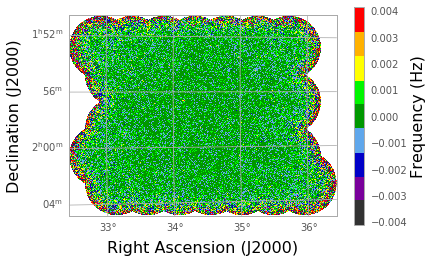

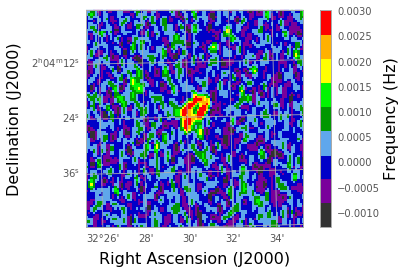

In [5]:
full_sliced = cube_data[471, :, :]
plot_slice(full_sliced, hi_data)
source_slice = cube_data[470, 980:1080, 980:1080]
plot_slice(source_slice, hi_data)

Artifical galaxies

FREQ-OHEL


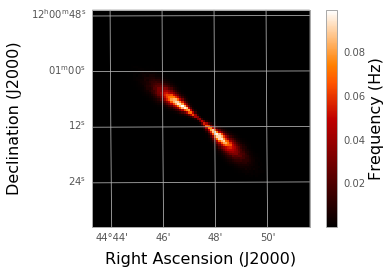

In [61]:
gal_data = fits.open('data/model1000.fits')
gal_cube_data = gal_data[0].data
gal_data[0].header['CTYPE3'] = 'FREQ'
gal_wcs = WCS(gal_data[0].header)
gal_data.close() 

# Slice
gal_slice = gal_cube_data[100, 150:250, 150:250]
# Mask
# masked = (gal_slice > np.mean(gal_slice)).astype(int)*gal_slice
# masked = np.ma.masked_where(gal_slice > np.mean(gal_slice), gal_slice)


fig = plt.figure()
ax = fig.add_subplot(projection=gal_wcs, slices=('y', 'x', 100))
im = ax.imshow(gal_slice, origin='lower')
cbar = plt.colorbar(im)
cbar.set_label('Frequency (Hz)', size=16)
plt.xlabel('Right Ascension (J2000)', fontsize=16)
plt.ylabel('Declination (J2000)', fontsize=16)
plt.show()

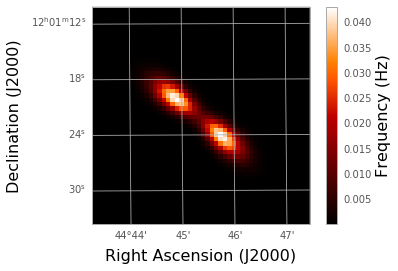

In [60]:
# assume our telescope has 1 arcsecond resolution
telescope_resolution = 15*u.arcsecond

# calculate the sigma in pixels.
sigma = telescope_resolution.to('deg').value/gal_data[0].header['CDELT2']
# By default, the Gaussian kernel will go to 4 sigma in each direction
psf = Gaussian2DKernel(sigma)
convolved_image = convolve_fft(gal_slice, psf, boundary='wrap')

# Put a psf at the corner of the image
# delta_x_psf=100 # number of pixels from the edges
# xmin, xmax = -psf.shape[1]-delta_x_psf, -delta_x_psf
# ymin, ymax = delta_x_psf, delta_x_psf+psf.shape[0]
# convolved_image[xmin:xmax, ymin:ymax] = psf.array/psf.array.max()*10

# Shrink
convolved_image = cv2.resize(convolved_image, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)

fig = plt.figure()
ax = fig.add_subplot(projection=gal_wcs, slices=('y', 'x', 100))
im = ax.imshow(convolved_image, origin='lower')
cbar = plt.colorbar(im)
cbar.set_label('Frequency (Hz)', size=16)
plt.xlabel('Right Ascension (J2000)', fontsize=16)
plt.ylabel('Declination (J2000)', fontsize=16)
plt.show()


Take slice around existing source and add mock source

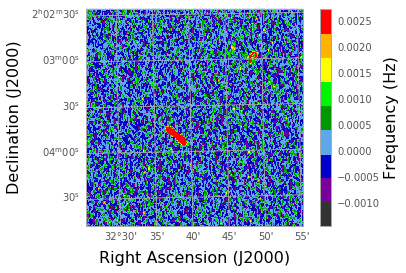

In [63]:
source_slice = cube_data[470, 800:1100, 800:1100]
insert_loc = source_slice[100:100+convolved_image.shape[0], 100:100+convolved_image.shape[1]]
source_slice[100:100+convolved_image.shape[0], 100:100+convolved_image.shape[1]] = convolved_image+ insert_loc
plot_slice(source_slice, hi_data)

# Traditional Methods

## Thresholding

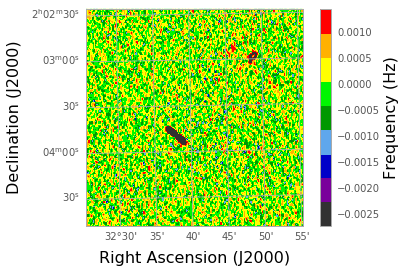

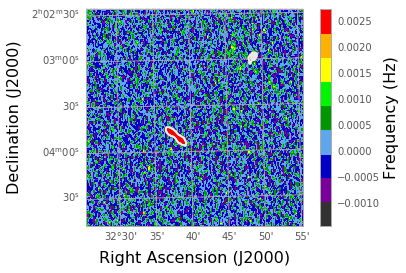

In [75]:
masked = source_slice > np.mean(source_slice) + 1*np.std(source_slice)
plot_slice(source_slice-masked, hi_data)
plot_slice(source_slice, hi_data, mask=masked)

## Region-based segmentation


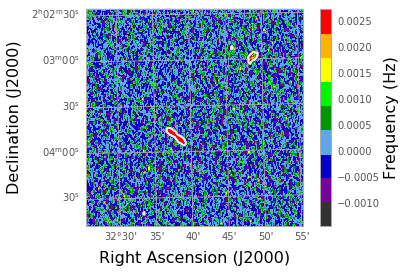

In [53]:
elevation_map = filters.sobel(source_slice)
markers = np.zeros_like(source_slice)
markers[source_slice < 0.001] = 1
markers[source_slice > 0.002] = 2
segmentated = segmentation.watershed(elevation_map, markers)
segmentated = ndi.binary_fill_holes(segmentated - 1)
plot_slice(source_slice, hi_data, segmentated)

## Edge-based segmentation

/opt/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


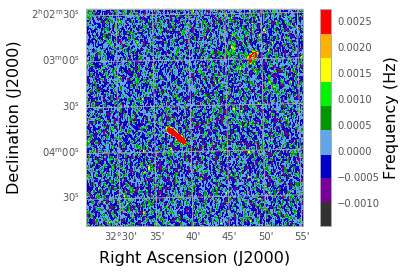

In [58]:
edges = canny(source_slice)
fill = ndi.binary_fill_holes(edges)
cleaned = morphology.remove_small_objects(fill, 10)
plot_slice(source_slice, hi_data, mask=cleaned)

# Unspervised Segmentation

## K Means Clustering

In [55]:
# kmeans = KMeans(n_clusters=3, random_state=0).fit(source_slice)
# cluster_pic = kmeans.cluster_centers_[kmeans.labels_]
# plot_slice(source_slice, hi_data, cluster_pic)

## Supervised Learning

## Random Forests